In [1]:
from ipy_oxdna.umbrella_sampling import MeltingUmbrellaSampling
from ipy_oxdna.oxdna_simulation import SimulationManager

import numpy as np
import pandas as pd
import os
from os.path import join
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'no-latex', 'bright'])

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************



In [5]:
path = os.path.abspath('/scratch/matthew/ipy_oxDNA/ipy_oxdna_examples/duplex_melting')

file_dir_name = 'all_observables_runs'  #'NAME_OF_DIR_CONTAINING_OXDNA_DAT_TOP'
file_dir = join(path, file_dir_name) #f'{path}/{file_dir_name}'

sim_dir_name = '8_nt_duplex_melting_tutorial2' #'CHOSEN_NAME_WHERE_SIMULATION_WILL_BE_STORED'
sim_dir = join(file_dir, sim_dir_name)   #f'{path}/{sim_dir_name}'

# Initialize the umbrella sampling object, this will create the simulation directory

# Clean build has 3 options, False, True and 'force' False will not allow you to overwrite
# existing simulation directories, True will overwrite existing simulation directories after asking for confirmation
# 'force' will overwrite existing simulation directories without asking for confirmation
us = MeltingUmbrellaSampling(file_dir, sim_dir, clean_build=True)

# The simulation manager object is used to run the simulation is non-blocking subprocesses,
# and will optimally allocate the simulations to available resources
simulation_manager = SimulationManager()

In [6]:
# Indexes of nucleotides to apply forces to and measure distance between (Order Parameter(OP))
com_list = '8,9,10,11,12,13,14,15'
ref_list = '7,6,5,4,3,2,1,0'

# Order of input nucleotides is import to collect the hb_contacts CV correctly, irrelevant for all else
com_list = ','.join(sorted(com_list.split(','))[::-1])
ref_list = ','.join(sorted(ref_list.split(',')))

# Minimum and maximum distance between nucleotides the simulations will attempt to pull the OP 
xmin = 0
xmax = 15

# Number of simulation windows/replicas
n_windows = 56

# Stiffness of the COM harmonic bias potential
stiff = 5

# Temperature of the simulation
temperature = "50C"

# Starting_r0 is only relevant if you run the pre_equlibration step,
# needed if you have large stiffness values and range of the OP is large but dosen't hurt to always run quickly
# Not possible to know before you run the simulation but you can run a till they print once,
# terminate and paste the starting_r0 value from the output file
starting_r0 = 0.4213

# Frequecny of printing the CVs to file
print_every = 1e4

# Name of file to save all but one of the CVs to, it is possible this cannot be changed
obs_filename = 'all_observables.txt'

# Name of file to save the hb_contacts CV to
hb_contact_filename = 'hb_contacts.txt'

# Number of simulation steps to run for each window
pre_eq_steps = 1e6  # This only need to short
eq_steps = 5e6  # This needs to be long enough to equilibrate the system
prod_steps = 2e8 # This needs to be long enough to get converged free energy profiles (methods to check are provided)

# Setup the custom hb_contacts CV
particle_indexes = [com_list, ref_list]
hb_contact_observable = [{'idx':particle_indexes, 'name':f'{hb_contact_filename}', 'print_every':int(print_every)}]

# oxDNA Simulation parameters
pre_equlibration_parameters = {
    'backend':'CPU', 'steps':f'{pre_eq_steps}','print_energy_every': f'{pre_eq_steps // 10}',
    'print_conf_interval':f'{pre_eq_steps // 2}', "CUDA_list": "no",'use_edge': 'false',
    'refresh_vel': '1','fix_diffusion': '0', 'T':f'{temperature}'}

equlibration_parameters = {
    'backend':'CPU','steps':f'{eq_steps}','print_energy_every': f'{eq_steps// 10}',
    'print_conf_interval':f'{eq_steps // 2}', "CUDA_list": "no",'use_edge': 'false',
    'refresh_vel': '1', 'fix_diffusion': '0', 'T':f'{temperature}'}

production_parameters = {
    'backend':'CPU', 'steps':f'{prod_steps}','print_energy_every': f'{prod_steps}',
    'print_conf_interval':f'{prod_steps}', "CUDA_list": "no", 'use_edge': 'false',
    'refresh_vel': '1','fix_diffusion': '0', 'T':f'{temperature}'}





In [ ]:
# This will build the pre_equlibration runs and queue them in the simulation manager

us.build_pre_equlibration_runs(
    simulation_manager, n_windows, com_list, ref_list, stiff, xmin, xmax,
    pre_equlibration_parameters, starting_r0, pre_eq_steps, continue_run=False,
    # If you want to continue a previous simulation set continue_run=int(n_steps)
    
    print_every=print_every, observable=True, protein=None, sequence_dependant=True,
    force_file=None, name=obs_filename, custom_observable=hb_contact_observable)

In [ ]:
simulation_manager.run(cpu_run=True) # This will run the simulation in the background (non-blocking)
#simulation_manager.worker_manager(cpu_run=True) # This will run the simulation in the foreground (blocking)

spawning


Running: 0
Running: 1
Running: 2
Running: 3
Running: 4
Running: 5
Running: 6
Running: 7
Running: 8
Running: 9
Running: 10
Running: 11
Running: 12
Running: 13
Running: 14
Running: 15
Running: 16
Running: 17
Running: 18
Running: 19
Running: 20
Running: 21
Running: 22
Running: 23
Running: 24
Running: 25
Running: 26
Running: 27
Running: 28
Running: 29
Running: 30
Running: 31
Running: 32
Running: 33
Running: 34
Running: 35
Running: 36
Running: 37
Running: 38
Running: 39
Running: 40
Running: 41
Running: 42
Running: 43
Running: 44
Running: 45
Running: 46
Running: 47
Running: 48
Running: 49
Running: 50
Run time: 33.512793412432075
Finished: 23
Running: 51


INFO: Lists updated 3521 times (every ~284.010224 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 40.177 KB written to files
	682.000  B written to stdout/stderr
	For a total of  0.00126 MB/s



Run time: 33.87333197519183
Finished: 22
Running: 52


INFO: Lists updated 3420 times (every ~292.397661 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 40.221 KB written to files
	682.000  B written to stdout/stderr
	For a total of  0.00124 MB/s



Run time: 33.99903731420636
Finished: 26
Running: 53


INFO: Lists updated 3628 times (every ~275.633958 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 40.142 KB written to files
	682.000  B written to stdout/stderr
	For a total of  0.00123 MB/s



Run time: 33.328978568315506
Finished: 34
Running: 54


INFO: Lists updated 3309 times (every ~302.206105 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 40.305 KB written to files
	682.000  B written to stdout/stderr
	For a total of  0.00127 MB/s



Run time: 34.06288892775774
Finished: 36
Running: 55
Run time: 33.33553062193096
Finished: 43
Run time: 33.15111017972231
Finished: 46


INFO: Lists updated 3537 times (every ~282.725474 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 40.175 KB written to files
	682.000  B written to stdout/stderr
	For a total of  0.00123 MB/s

INFO: Lists updated 3525 times (every ~283.687943 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 40.169 KB written to files
	682.000  B written to stdout/stderr
	For a total of  0.00126 MB/s



Run time: 34.65543611161411
Finished: 33
Run time: 33.4971241671592
Finished: 44
Run time: 32.834605265408754
Finished: 50
Run time: 34.87127902172506
Finished: 32
Run time: 35.10412252135575
Finished: 30
Run time: 34.3697677385062


INFO: Lists updated 3581 times (every ~279.251606 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 40.346 KB written to files
	682.000  B written to stdout/stderr
	For a total of  0.00127 MB/s

INFO: Lists updated 3602 times (every ~277.623542 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 40.146 KB written to files
	682.000  B written to stdout/stderr
	For a total of  0.00121 MB/s

INFO: Lists updated 3718 times (every ~268.961807 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 40.247 KB written to files
	682.000  B written to stdout/stderr
	For a total of  0.00126 MB/s

INFO: Lists updated 3543 times (every ~282.246684 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 40.197 KB written to files
	682.000  B written to stdout/stderr
	For a total of  0.00128 MB/s

INFO: Lists updated 3512 times (every ~284.738041 steps)
INFO: Aggregated I/O statistics (set de

Finished: 37
Run time: 33.96359764970839
Finished: 42


INFO: Lists updated 3566 times (every ~280.426248 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 40.122 KB written to files
	682.000  B written to stdout/stderr
	For a total of  0.00122 MB/s

INFO: Lists updated 3659 times (every ~273.298715 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 40.330 KB written to files
	682.000  B written to stdout/stderr
	For a total of  0.00124 MB/s



Run time: 35.5964139085263
Finished: 28
Run time: 34.32277320884168
Finished: 40
Run time: 34.937573816627264
Finished: 35
Run time: 35.877673948183656
Finished: 27
Run time: 33.54543496854603
Finished: 48


INFO: Lists updated 3654 times (every ~273.672687 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 40.109 KB written to files
	682.000  B written to stdout/stderr
	For a total of  0.00118 MB/s

INFO: Lists updated 3475 times (every ~287.769784 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 40.133 KB written to files
	682.000  B written to stdout/stderr
	For a total of  0.00122 MB/s

INFO: Lists updated 3441 times (every ~290.613194 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 40.233 KB written to files
	682.000  B written to stdout/stderr
	For a total of   0.0012 MB/s

INFO: Lists updated 3689 times (every ~271.076172 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 40.162 KB written to files
	682.000  B written to stdout/stderr
	For a total of  0.00117 MB/s

INFO: Lists updated 3648 times (every ~274.122807 steps)
INFO: Aggregated I/O statistics (set de

Run time: 33.931085316464305
Finished: 45
Run time: 33.81720253266394
Finished: 47
Run time: 34.882419411093
Finished: 38
Run time: 35.87889045290649
Finished: 29


INFO: Lists updated 3478 times (every ~287.521564 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 40.280 KB written to files
	682.000  B written to stdout/stderr
	For a total of  0.00124 MB/s

INFO: Lists updated 3733 times (every ~267.881061 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 40.269 KB written to files
	682.000  B written to stdout/stderr
	For a total of  0.00125 MB/s

INFO: Lists updated 3586 times (every ~278.862242 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 40.269 KB written to files
	682.000  B written to stdout/stderr
	For a total of   0.0012 MB/s

INFO: Lists updated 3328 times (every ~300.480769 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 40.293 KB written to files
	682.000  B written to stdout/stderr
	For a total of  0.00117 MB/s



Run time: 34.86997735872865
Finished: 39
Run time: 34.702830888330936
Finished: 41
Run time: 36.51049929857254
Finished: 25
Run time: 33.906560165807605
Finished: 49


INFO: Lists updated 3546 times (every ~282.007896 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 40.212 KB written to files
	682.000  B written to stdout/stderr
	For a total of  0.00121 MB/s

INFO: Lists updated 3189 times (every ~313.577924 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 40.149 KB written to files
	682.000  B written to stdout/stderr
	For a total of  0.00121 MB/s

INFO: Lists updated 3713 times (every ~269.323997 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 40.299 KB written to files
	682.000  B written to stdout/stderr
	For a total of  0.00115 MB/s

INFO: Lists updated 3454 times (every ~289.519398 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 40.264 KB written to files
	682.000  B written to stdout/stderr
	For a total of  0.00125 MB/s



Run time: 36.533743027597666
Finished: 31


INFO: Lists updated 3246 times (every ~308.071473 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 40.103 KB written to files
	682.000  B written to stdout/stderr
	For a total of  0.00114 MB/s



Run time: 37.62087850831449
Finished: 24


INFO: Lists updated 3402 times (every ~293.944738 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 40.062 KB written to files
	682.000  B written to stdout/stderr
	For a total of  0.00111 MB/s



Run time: 39.40427413582802
Finished: 20


INFO: Lists updated 3519 times (every ~284.171640 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 40.268 KB written to files
	682.000  B written to stdout/stderr
	For a total of  0.00106 MB/s



Run time: 40.28395553864539
Finished: 19
Run time: 40.4684127997607
Finished: 18
Run time: 40.63815912976861
Finished: 17


INFO: Lists updated 3494 times (every ~286.204923 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 40.021 KB written to files
	682.000  B written to stdout/stderr
	For a total of  0.00103 MB/s

INFO: Lists updated 3692 times (every ~270.855905 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 40.009 KB written to files
	682.000  B written to stdout/stderr
	For a total of  0.00102 MB/s

INFO: Lists updated 3247 times (every ~307.976594 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 40.037 KB written to files
	682.000  B written to stdout/stderr
	For a total of  0.00102 MB/s



Run time: 40.37403182685375
Finished: 21


INFO: Lists updated 3656 times (every ~273.522976 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 40.287 KB written to files
	682.000  B written to stdout/stderr
	For a total of  0.00104 MB/s



Run time: 42.36838569492102
Finished: 12


INFO: Lists updated 3194 times (every ~313.087038 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 40.094 KB written to files
	682.000  B written to stdout/stderr
	For a total of 0.000975 MB/s



Run time: 44.40416361950338
Finished: 4


INFO: Lists updated 2877 times (every ~347.584289 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 39.952 KB written to files
	682.000  B written to stdout/stderr
	For a total of 0.000924 MB/s



Run time: 43.32206370681524
Finished: 16
Run time: 43.990039920434356
Finished: 11
Run time: 43.575678043067455
Finished: 15


INFO: Lists updated 3232 times (every ~309.405941 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 40.052 KB written to files
	682.000  B written to stdout/stderr
	For a total of 0.000955 MB/s

INFO: Lists updated 2922 times (every ~342.231348 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 40.077 KB written to files
	682.000  B written to stdout/stderr
	For a total of 0.000939 MB/s

INFO: Lists updated 3177 times (every ~314.762354 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 39.949 KB written to files
	682.000  B written to stdout/stderr
	For a total of 0.000947 MB/s



Run time: 46.26426023989916
Finished: 2


INFO: Lists updated 3260 times (every ~306.748466 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 39.933 KB written to files
	682.000  B written to stdout/stderr
	For a total of 0.000887 MB/s



Run time: 45.30164782144129
Finished: 13
Run time: 45.83144363947213
Finished: 9
Run time: 46.13612124323845
Finished: 7


INFO: Lists updated 3622 times (every ~276.090558 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 39.905 KB written to files
	682.000  B written to stdout/stderr
	For a total of 0.000909 MB/s

INFO: Lists updated 3070 times (every ~325.732899 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 40.134 KB written to files
	682.000  B written to stdout/stderr
	For a total of 0.000901 MB/s

INFO: Lists updated 3229 times (every ~309.693404 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 40.024 KB written to files
	682.000  B written to stdout/stderr
	For a total of 0.000892 MB/s



Run time: 45.413865922018886
Finished: 14
Run time: 46.23300887271762
Finished: 8


INFO: Lists updated 3308 times (every ~302.297461 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 40.034 KB written to files
	682.000  B written to stdout/stderr
	For a total of 0.000909 MB/s

INFO: Lists updated 3509 times (every ~284.981476 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 39.923 KB written to files
	682.000  B written to stdout/stderr
	For a total of 0.000889 MB/s



Run time: 47.03352958895266
Finished: 6
Run time: 47.20186877064407
Finished: 5
Run time: 46.70654395595193
Finished: 10


INFO: Lists updated 3189 times (every ~313.577924 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 39.955 KB written to files
	682.000  B written to stdout/stderr
	For a total of 0.000873 MB/s

INFO: Lists updated 2763 times (every ~361.925443 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 39.967 KB written to files
	682.000  B written to stdout/stderr
	For a total of 0.000869 MB/s

INFO: Lists updated 3044 times (every ~328.515112 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 39.937 KB written to files
	682.000  B written to stdout/stderr
	For a total of 0.000879 MB/s



Run time: 47.85917375795543
Finished: 1


INFO: Lists updated 2799 times (every ~357.270454 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 39.924 KB written to files
	682.000  B written to stdout/stderr
	For a total of 0.000855 MB/s



Run time: 48.51191793568432
Finished: 3


INFO: Lists updated 3033 times (every ~329.706561 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 39.988 KB written to files
	682.000  B written to stdout/stderr
	For a total of 0.000845 MB/s



Run time: 50.58662752993405
Finished: 0


INFO: Lists updated 2451 times (every ~407.996736 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 39.923 KB written to files
	682.000  B written to stdout/stderr
	For a total of 0.000808 MB/s



Run time: 16.70241380482912
Finished: 51


INFO: Lists updated 3906 times (every ~256.016385 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 40.310 KB written to files
	682.000  B written to stdout/stderr
	For a total of  0.00255 MB/s



Run time: 15.972380572929978
Finished: 54
Run time: 16.2921645604074
Finished: 53


INFO: Lists updated 3937 times (every ~254.000508 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 40.215 KB written to files
	682.000  B written to stdout/stderr
	For a total of  0.00266 MB/s

INFO: Lists updated 3703 times (every ~270.051310 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 40.285 KB written to files
	682.000  B written to stdout/stderr
	For a total of  0.00261 MB/s



Run time: 16.01183213479817
Finished: 55


INFO: Lists updated 3647 times (every ~274.197971 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 40.341 KB written to files
	682.000  B written to stdout/stderr
	For a total of  0.00266 MB/s



Run time: 19.438512310385704
Finished: 52


INFO: Lists updated 3458 times (every ~289.184500 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 40.346 KB written to files
	682.000  B written to stdout/stderr
	For a total of  0.00218 MB/s



All queued simulations finished in: 56.209204440936446


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


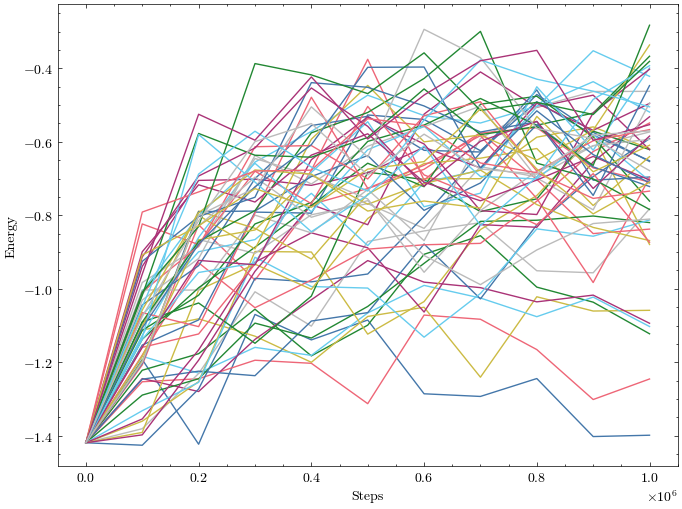

In [5]:
# This will provide access to the pre_equlibration simulations information
pre_eq_sims = us.pre_equlibration_sims

# View conf interactivly in jupyter notebook
pre_eq_sims[0].analysis.view_last() # .view_init(), .view_conf(conf_number), .get_conf_count()

# Plot the energy of the pre_equlibration simulations
fig, ax = plt.subplots(figsize=(8, 6))
for sim in pre_eq_sims:
    sim.analysis.plot_energy(fig=fig, ax=ax)
plt.legend()


In [7]:

# You will need to reinitalize the observables if you did not build the dirs in your current kernel, I want to fix this
us.observables_list = []
us.initialize_observables(com_list, ref_list, print_every=print_every, name=obs_filename)

# Read collected variable into us.obs_df a list of n_windows dataframes
# The number of datapoints can vary between windows during run time, disallowing arrays
us.analysis.read_all_observables('pre_eq')
# us.read_hb_contacts('pre_eq')

us.obs_df[0].head()


,com_distance,hb_list,force_energy_0,kinetic_energy,backbone,bonded_excluded_volume,stacking,nonbonded_excluded_volume,hydrogen_bonding,cross_stacking,coaxial_stacking,debye_huckel,steps,hb_contact
0,0.4213,8.0,0.104637,0.294999,0.035818,0.0,-1.019780,0.0,-0.322364,-0.113485,0.0,0.000815,0,0.749651
1,0.5132,8.0,0.071858,0.271332,0.046718,0.0,-1.027345,0.0,-0.376989,-0.120876,0.0,0.000632,10000,0.749536
2,0.5861,8.0,0.049819,0.269298,0.068580,0.0,-1.112466,0.0,-0.314313,-0.095587,0.0,0.000670,20000,0.749253
3,0.4411,8.0,0.090084,0.224705,0.054973,0.0,-0.997968,0.0,-0.315032,-0.094260,0.0,0.000624,30000,0.742373
4,0.4366,7.0,0.089142,0.283973,0.073359,0.0,-1.057049,0.0,-0.293510,-0.111167,0.0,0.001165,40000,0.741829


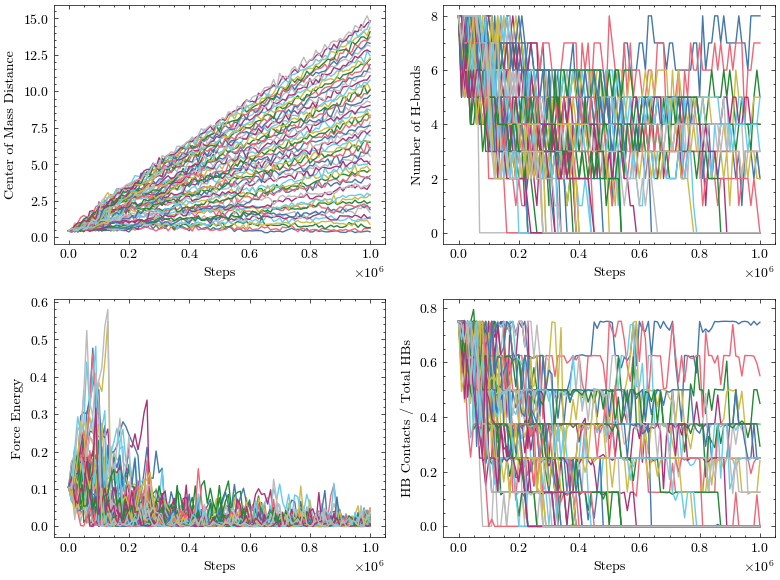

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6),)

for df in us.obs_df:
    ax[0,0].plot(df['steps'], df['com_distance'])
    ax[0,1].plot(df['steps'], df['hb_list'])
    ax[1,0].plot(df['steps'], df['force_energy_0'])
    ax[1,1].plot(df['steps'], df['hb_contact'])

ax[0,0].set_ylabel('Center of Mass Distance')
ax[0,1].set_ylabel('Number of H-bonds')
ax[1,0].set_ylabel('Force Energy')
ax[1,1].set_ylabel('HB Contacts / Total HBs')

ax[0,0].set_xlabel('Steps')
ax[0,1].set_xlabel('Steps')
ax[1,0].set_xlabel('Steps')
ax[1,1].set_xlabel('Steps')

fig.tight_layout()

In [17]:
us.build_equlibration_runs(
    simulation_manager, n_windows, com_list, ref_list,
    stiff, xmin, xmax, equlibration_parameters, continue_run=False,
    
    print_every=print_every, observable=True, protein=None, name=obs_filename,
    force_file=None,  custom_observable=hb_contact_observable)


In [ ]:
simulation_manager.run(cpu_run=True)

spawning


Running: 0
Running: 1
Running: 2
Running: 3
Running: 4
Running: 5
Running: 6
Running: 7
Running: 8
Running: 9
Running: 10
Running: 11
Running: 12
Running: 13
Running: 14
Running: 15
Running: 16
Running: 17
Running: 18
Running: 19
Running: 20
Running: 21
Running: 22
Running: 23
Running: 24
Running: 25
Running: 26
Running: 27
Running: 28
Running: 29
Running: 30
Running: 31
Running: 32
Running: 33
Running: 34
Running: 35
Running: 36
Running: 37
Running: 38
Running: 39
Running: 40
Running: 41
Running: 42
Running: 43
Running: 44
Running: 45
Running: 46
Running: 47
Running: 48
Running: 49
Running: 50


In [ ]:
us.observables_list = []
us.initialize_observables(com_list, ref_list, print_every=print_every, name=obs_filename)
us.analysis.read_all_observables('eq')

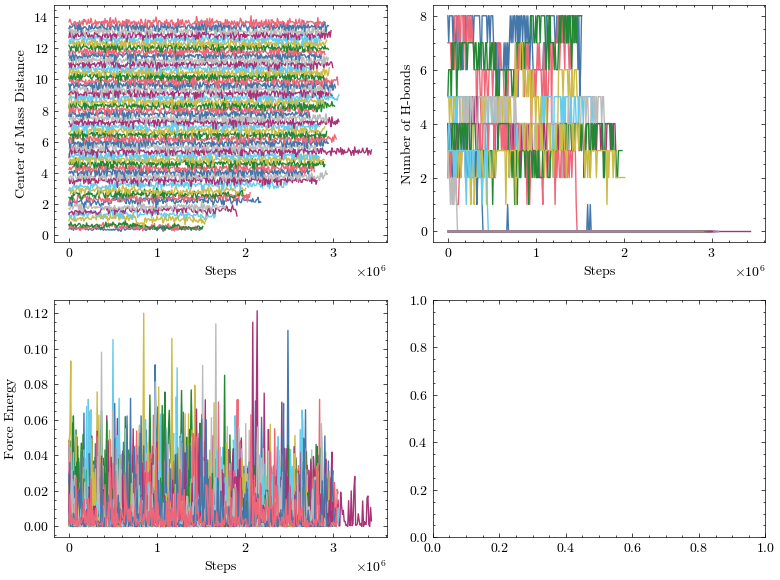

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6),)

for df in us.obs_df:
    ax[0,0].plot(df['steps'], df['com_distance'])
    ax[0,1].plot(df['steps'], df['hb_list'])
    ax[1,0].plot(df['steps'], df['force_energy_0'])
    ax[1,0].plot(df['steps'], df['force_energy_0'])


ax[0,0].set_ylabel('Center of Mass Distance')
ax[0,1].set_ylabel('Number of H-bonds')
ax[1,0].set_ylabel('Force Energy')

ax[0,0].set_xlabel('Steps')
ax[0,1].set_xlabel('Steps')
ax[1,0].set_xlabel('Steps')

fig.tight_layout()